# Gráficos de hidrofobicidade a partir da escala Kyte-Doolittle

## Escala Kyte-Doolittle

[https://resources.qiagenbioinformatics.com/manuals/clcgenomicsworkbench/650/Hydrophobicity_scales.html]

Na escala de hidrofobicidade de Kyte-Doolittle, regiões com valores positivos são hidrofóbicas, enquanto regiões com valores negativos são hidrofílicas. A escala pode ser usada para identificar regiões transmembrana dependendo do tamanho da janela (quantidade de aminoácidos) escolhida.

Primeiro, criamos um dicionário com os valores de hidrofilicidade/hidrofobicidade de cada aminoácido pela referência acima:

In [1]:
hidropathy = {
    'A' : 1.80, # alanine
    'C' : 2.50, # cysteine
    'D' : -3.50, # aspartic acid
    'E' : -3.50, # glutamic acid
    'F' : 2.80, # phenylalanine
    'G' : -0.40, # glycine
    'H' : -3.20, # histidine
    'I' : 4.50, # isoleucine
    'K' : -3.90, # lysine
    'L' : 3.80, # leucine
    'M' : 1.90, # methionine
    'N' : -3.50, # asparagine
    'P' : -1.60, # proline
    'Q' : -3.50, # glutamine
    'R' : -4.50, # arginine
    'S' : -0.80, # serine
    'T' : -0.70, # threonine
    'V' : 4.20, # valine
    'W' : -0.90, # tryptophan
    'Y' : -1.30, # tyrosine
}

## Tratamento dos dados

Primeiro, definimos nossas sequências FASTA

In [2]:
FASTA_HA1 = 'ADADDTICIGYHANNSTDTVDTVLEKNVTVTHSVNLLEDSHNGKLCRLKGIAPLQLGKCNIAGWLLGNPECDPLLPVRSWSYIVETPNSENGICYPGDFIDYEELREQLSSVSSFERFEIFPKESSWPNHNTNGVTAACSHEGKSSFYRNLLWLTEKEGSYPKLKNSYVNKKGKEVLVLWGIHHPPNSKEQQNLYQNENAYVSVVTSNYNRRFTPEIAERPKVRDQAGRMNYYWTLLKPGDTIIFEANGNLIAPMYAFALRRGFGSGIITSNASMHECNTKCQTPLGAINSSLPYQNIHPVTIGECPKYVRSAKLRMVTGLRNIPAR'
FASTA_HA2 = 'GLFGAIAGFIEGGWTGMIDGWYGYHHQNEQGSGYAADQKSTQNAINGITNKVNSVIEKMNIQFTAVGKEFNKLEKRMENLNNKVDDGFLDIWTYNAELLVLLENERTLDFHDSNVKNLYEKVKSQLKNNAKEIGNGCFEFYHKCDNECMESVRNGTYDYP'


Devemos agora tratar essas sequências para diminuir a poluição pela diferença de hidropatia dos aminoácidos. É possível criar "janelas" de análise que podem deixar os gráficos mais limpos, de maneira a não perder o essencial [http://www.dalkescientific.com/writings/NBN/plotting.html]. No nosso caso, vamos usar a média de 3 aminoácidos para computar variações de hidrofobicidade.

In [17]:
def limpa_amino(seq, qtd=3, eixo_amino=False):
    """
    Args: sequência FASTA a ser simplificada
    Returns: sequência FASTA simplicada ou sequência FASTA simplicada + aminoácidos relacionados a ela
    """
    escala_kd = [hidropathy[i] for i in seq]
    escala_clean_kd = [(sum(escala_kd[j:(j+qtd+1)])/qtd) for j in range(1, len(escala_kd)-qtd, qtd)]

    escala_clean_kd.insert(0, escala_kd[0])
    escala_clean_kd.append(escala_kd[-1])

    if eixo_amino:
        eixo_aminoacidos = [i for i in range(0, len(escala_kd)+1, qtd)]
        return eixo_aminoacidos, escala_clean_kd # Serve para definir o eixo dos aminoácidos, posteriormente usado para o plot

    return escala_clean_kd

No nosso exemplo, obtemos duas listas:

In [18]:
a = limpa_amino(FASTA_HA1, eixo_amino=True)
b = limpa_amino(FASTA_HA2, eixo_amino=True)

## Plotando os gráficos

Podemos agora definir uma função para plotar os gráficos de hidrofobicidade com respeito aos aminoácidos. Nessa função, decidimos colorir as áreas hidrofóbicas dos aminoácidos para deixar mais visual as regiões hidrofóbicas. Temos o seguinte:

In [46]:
# Importações necessárias:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.colors as mcolors
from random import choice

In [54]:
def particao_lista(lst, size):
    return [lst[i:i + size + 1] for i in range(0, len(lst)-1, size)]

def pintura(aminoacidos, hidrofobicidade):
    """
    Args: recebe os valores de hidrofobicidade, o número dos aminoácidos associados aos valores e o nome da proteína avaliada
    Returns : a área que vai ser pintada no gráfico
    """

    x_fill = np.array([])
    y_fill = np.array([])

    particao_h = particao_lista(hidrofobicidade, 1)
    particao_a = particao_lista(aminoacidos, 1)
    associacao = zip(particao_a, particao_h)

    for i in associacao:
        poly = CubicSpline(*i) # Cria um polinômio que vai ligar ponto a ponto no gráfico
        x = np.linspace(i[0][0], i[0][1], 100) # Cria 100 valores entre cada ponto do gráfico
        y = poly(x)

        x_fill = np.append(x_fill, x[y>0])
        y_fill= np.append(y_fill, y[y>0])
        x_fill = np.array(x_fill).flatten()
        y_fill = np.array(y_fill).flatten()
    
    return x_fill, y_fill

def grafico(aminoacidos, hidrofobicidade, nome_mol='molécula', fill=True):
    fig, ax = plt.subplots(figsize=(14,8))
    ax.set(
        title=f'Hidrofobicidade da {nome_mol} a partir da escala Kyte-Doolitlle',
        xlabel='Aminoácidos',
        ylabel='Hidrofobicidade média a cada 3 aminoácidos',
        xlim=(-0.5, aminoacidos[-1]),
        facecolor='ivory',
    )
    if fill:
        x_fill, y_fill = pintura(aminoacidos, hidrofobicidade)
        all_colors = list(mcolors.CSS4_COLORS.keys()) + list(mcolors.TABLEAU_COLORS.keys()) + list(mcolors.XKCD_COLORS.keys()) # pega todas as cores do matplotlib
        ax.fill_between(x_fill, y_fill, color=choice(all_colors), alpha=0.8, label='Área sob a curva')

    ax.plot(aminoacidos, hidrofobicidade, color='black')
    ax.axhline(0, color='black', lw=3)
    
    plt.show()
    plt.savefig(fname=f'hidrofob_{nome_mol.strip()}')

Para nossas proteínas exemplo, temos:

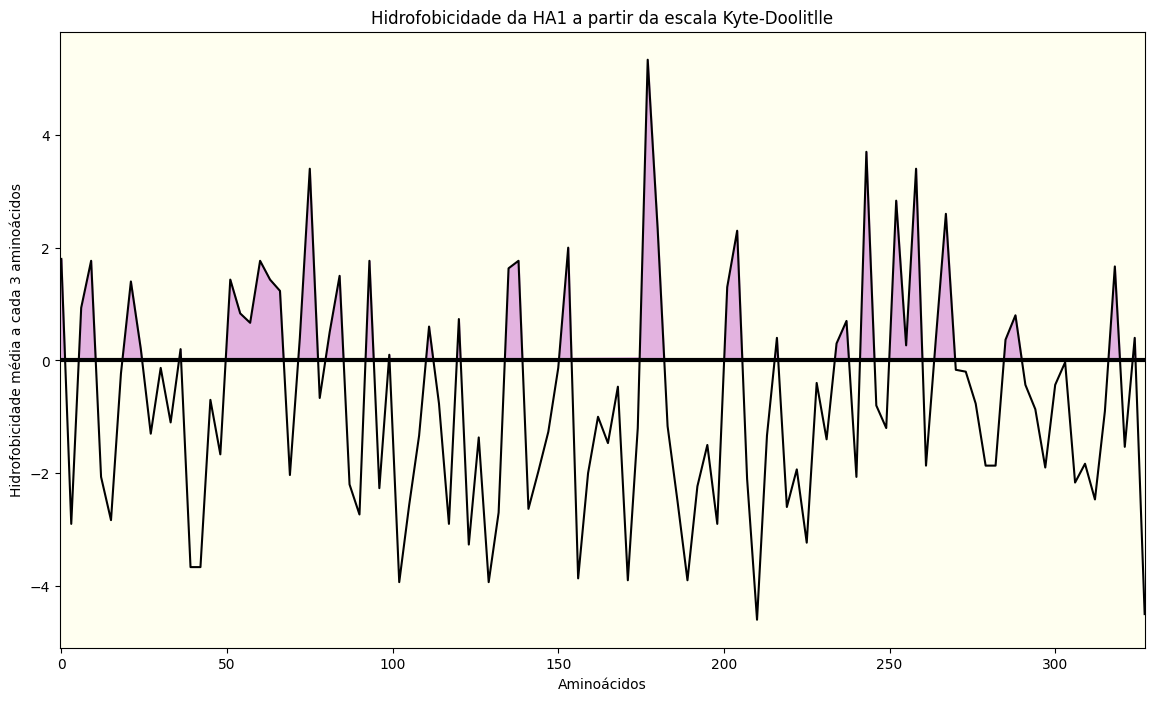

<Figure size 640x480 with 0 Axes>

In [55]:
grafico(a[0], a[1], nome_mol='HA1')

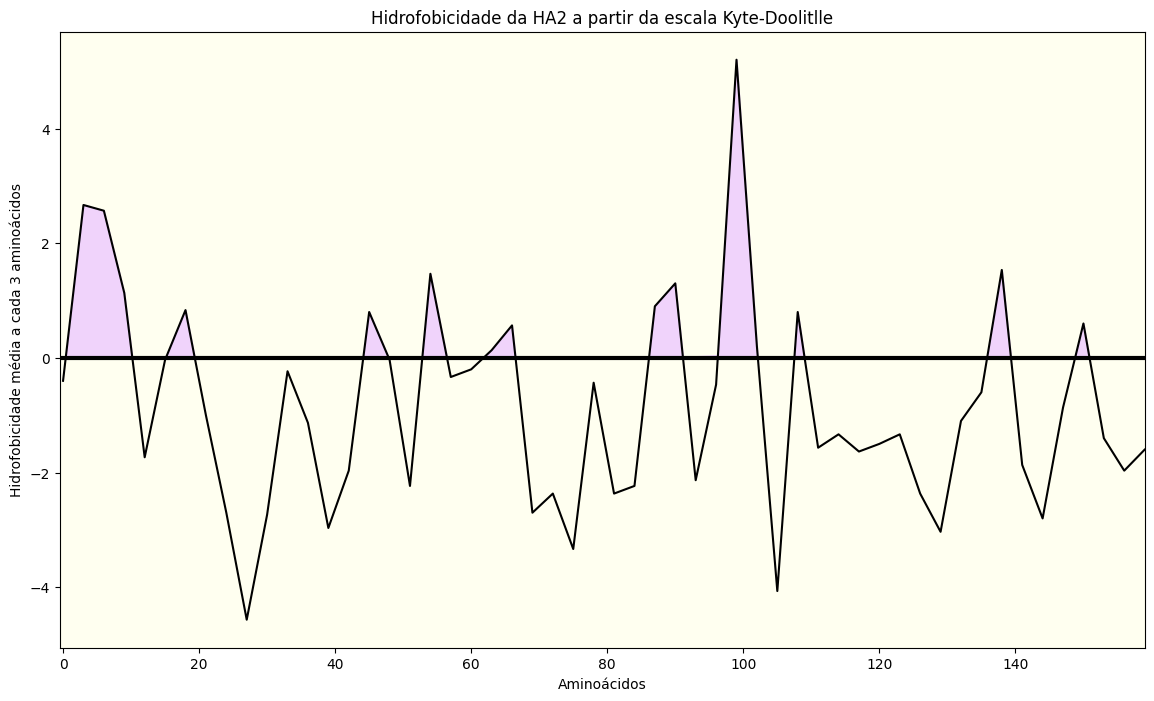

In [53]:
grafico(b[0], b[1], nome_mol='HA2')

É isso! Qualquer complicação, basta chamar!